In [2]:
# Parent directory import
import sys
sys.path.append('/home/rajkinra23/git/drip_vision/')

import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os


In [113]:
torch.cuda.is_available()

True

In [3]:
# Reference article: https://www.kaggle.com/code/robinreni/signature-classification-using-siamese-pytorch

In [20]:
# Pointer to the data locations

ROOT = "/home/rajkinra23/git/drip_vision/data/embeddings_dataset"

class DataConfig():
    def __init__(self, root):
        self.train_dir = f"{root}/train"
        self.test_dir = f"{root}/test"

    def num_train_objects(self):
        return len(os.listdir(self.train_dir))
    
    def num_test_objects(self):
        return len(os.listdir(self.test_dir))
    
    def train_test_ratio(self):
        return self.num_train_objects()/self.num_test_objects()
    
data_cfg = DataConfig(ROOT)
folder_dataset = datasets.ImageFolder(root=data_cfg.train_dir)
test_dataset = datasets.ImageFolder(root=data_cfg.test_dir)


In [21]:
# Create map from image class to images. Helps with choosing pairs later on
from collections import defaultdict

class_image_lookup = defaultdict(list)
for pair in folder_dataset.imgs:
    image_path, image_class = pair
    class_image_lookup[image_class].append(image_path)
    
print(random.choice(class_image_lookup[100]))

/home/rajkinra23/git/drip_vision/data/embeddings_dataset/train/0400010888319/0400010888319_A0_0.jpg


In [22]:
# Implement torch data loader

def preprocess(image):
    image = Image.open(image)
    image = image.convert("L")
    transform = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()])
    image = transform(image)
    return image

class SiameseNetworkDataset(Dataset):
    
    def __init__(self, image_folder_dataset, transform=None, should_invert=True):
        self.image_folder_dataset = image_folder_dataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        # Pick a random image from the dataset
        first_image, first_image_class = random.choice(self.image_folder_dataset.imgs)
        
        # Randomly roll to get the same class
        should_get_same_class = random.randint(0,1) 
        
        # In the event that we should pick the same class, pick a random sample from the same image
        # class (that's not the same image)
        if should_get_same_class:
            second_image_class = first_image_class
            second_image = random.choice(class_image_lookup[first_image_class])
            
        # Otherwise, pick something from a different image class. Ok to randomly choose from the whole dataset
        # here (low probability of collision)
        else:
            while True:
                second_image, second_image_class = random.choice(self.image_folder_dataset.imgs) 
                if first_image_class != second_image_class:
                    break

#         # Process images
#         first_image = Image.open(first_image)
#         first_image = first_image.convert("L")
#         second_image = Image.open(second_image)
#         second_image = second_image.convert("L")
        
#         # Maybe invert
#         if self.should_invert:
#             first_image = PIL.ImageOps.invert(first_image)
#             second_image = PIL.ImageOps.invert(second_image)

#         if self.transform is not None:
#             first_image = self.transform(first_image)
#             second_image = self.transform(second_image)
        
        return preprocess(first_image), preprocess(second_image), torch.from_numpy(np.array([int(first_image_class != second_image_class)], dtype=np.float32))
    
    def __len__(self):
        return len(self.image_folder_dataset.imgs)
    
# Build dataset
siamese_dataset = SiameseNetworkDataset(image_folder_dataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
test_dataset = SiameseNetworkDataset(image_folder_dataset=test_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

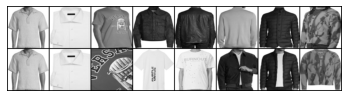

[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]]


In [23]:
# Util to show images
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    
# Visualize some data
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)

# Examine what contrastinc and different batches look like
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [119]:
# Define the network. Standard siamese from paper
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # First CNN
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),          
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 64))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
    def predict(self, image):
        image = preprocess(image)
        image = image.unsqueeze(0)
        image = image.to(self.device)
        print(image.size())
        print(image.device)
        return self.forward_once(image)
    
# Contrastive loss
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [120]:
# Check out the network
print(SiameseNetwork())

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=64, bias=True)
  )
)


In [38]:
# Set the loss function
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

# Containers for metrics
counter = []
loss_history = [] 
iteration_number= 0

# Set batch size and epocs
batch_size = 64
epochs = 100

# Train! Load the data
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=batch_size)

# Run training
for epoch in range(0, epochs):
    for i, data in enumerate(train_dataloader, 0):
        # Get images and labels
        first_image, second_image, label = data
        
        # Set the context to cuda
        first_image, second_image, label = first_image.cuda(), second_image.cuda(), label.cuda()
        
        # Zero out gradients
        optimizer.zero_grad()
        
        # Get output for the two images
        output1, output2 = net(first_image, second_image)
        
        # Compute contrastive loss.
        loss_contrastive = criterion(output1, output2, label)
        
        # Propogate loss backwards
        loss_contrastive.backward()
        
        # Conclude the step
        optimizer.step()
        
        # Log the current loss every 10 steps
        if i %10 == 0:
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

Epoch number 0
 Current loss 1.0218427181243896

Epoch number 0
 Current loss 2.7466068267822266

Epoch number 0
 Current loss 1.9621661901474

Epoch number 0
 Current loss 1.0093231201171875

Epoch number 0
 Current loss 0.49749255180358887

Epoch number 0
 Current loss 0.5355890393257141

Epoch number 0
 Current loss 0.4570692777633667

Epoch number 0
 Current loss 0.7842882871627808

Epoch number 0
 Current loss 0.634602963924408

Epoch number 0
 Current loss 0.7170984148979187

Epoch number 0
 Current loss 0.5865675210952759

Epoch number 0
 Current loss 0.5262030363082886

Epoch number 0
 Current loss 0.5879643559455872

Epoch number 0
 Current loss 0.5675883293151855

Epoch number 0
 Current loss 0.34530109167099

Epoch number 0
 Current loss 0.4510899484157562

Epoch number 0
 Current loss 0.6175747513771057

Epoch number 0
 Current loss 0.4104255735874176

Epoch number 0
 Current loss 0.5631579756736755

Epoch number 0
 Current loss 0.4324863851070404

Epoch number 0
 Current l

KeyboardInterrupt: 

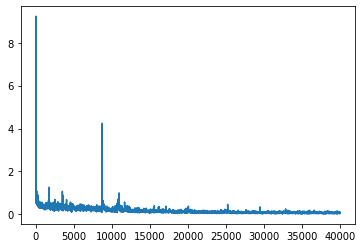

In [23]:
# Plot the training history
show_plot(counter,loss_history)

In [121]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("embedding_model.pt"))

<All keys matched successfully>

In [122]:
print(model)
print(model.device)

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=64, bias=True)
  )
)
cuda


torch.Size([1, 1, 100, 100])


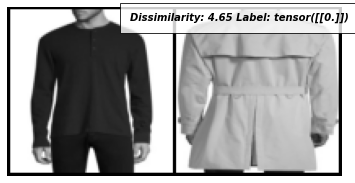

In [123]:
# Test drive similarity

# Counter
counter=0

# List of image pairs
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])

# Create test dataloader
test_dataloader = DataLoader(test_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=1)


# Iterate over test datlaoader
num_examples = 1
for i, data in enumerate(test_dataloader): 
    image_one, image_two, label = data
    print(image_one.size())
    concatenated = torch.cat((image_one, image_two),0)
    embedding_one, embedding_two = model(image_one.to(device),image_two.to(device))
    # print(embedding_one, embedding_two)
    eucledian_distance = float(torch.cdist(embedding_one, embedding_two))
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance,label))
    counter += 1
    if counter == num_examples:
        break

In [124]:
# Try model on random image

In [125]:
path = "/home/rajkinra23/git/drip_vision/experimental/test_image.jpg"
print(model.predict(path))

torch.Size([1, 1, 100, 100])
cuda:0
tensor([[ 1.9345e-02, -9.0393e-01, -1.4190e-01,  6.0522e-02,  3.3636e-02,
          1.6771e-02,  6.0325e-01, -5.3878e-01, -4.6210e-01,  8.1221e-03,
          1.1175e-01, -1.1449e-01,  9.9220e-02, -7.1480e-01, -2.9889e-02,
         -2.2799e-01,  1.5910e-01,  3.5611e-01, -3.1274e-01, -6.1375e-02,
          3.5250e-02,  2.4702e-02, -1.7167e-02,  6.8485e-02,  1.7082e-01,
         -3.0962e-02, -1.6360e+00,  1.6445e-01,  8.5047e-02, -3.8786e-01,
         -9.8836e-01,  1.1281e-01,  8.5460e-02, -2.0211e-02,  2.0184e-02,
          6.3316e-02,  1.4210e-01, -1.5051e-01, -3.5982e-03,  2.1700e-01,
          2.0395e-01,  4.0735e-02,  6.3758e-01,  1.1356e-02, -3.3164e-02,
         -1.2738e-01,  9.3128e-01,  1.0700e-01,  3.9027e-01, -4.5067e-02,
          3.2296e-02,  2.0766e-02, -2.7596e+00,  9.6933e-01, -9.3050e-02,
          2.3346e-03,  6.2116e-02, -1.8745e-02,  1.4991e-01, -2.9459e-03,
         -9.7188e-02,  2.1047e-01, -7.6262e-02,  2.6030e-01]], device='cuda: